### **Imports**

In [1]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import chi2
from sko.PSO import PSO
from sklearn.feature_selection import chi2
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import ttest_rel
from statistics import mean, stdev
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

### **Data Ingestion**

In [ ]:
# Carregamento de Dados
test = pd.read_csv(r'../datasets/test_data_cleaned.csv')
train = pd.read_csv(r'../datasets/training_data_cleaned.csv')
train = train.drop(columns=['hour', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN', 'month', 'AVERAGE_WIND_SPEED'])
test = test.drop(columns=['hour', 'AVERAGE_CLOUDINESS', 'AVERAGE_RAIN', 'month', 'AVERAGE_WIND_SPEED'])

### **Data Segregation**

In [3]:
y = train['AVERAGE_SPEED_DIFF']
X = train.drop(columns=['AVERAGE_SPEED_DIFF'])
X_test = test

### **Model Training**

In [4]:
rf = RandomForestClassifier(random_state=2025, n_jobs=-1, criterion='entropy', max_depth=30, n_estimators=200) 
lr = LogisticRegression(random_state=2025, max_iter=2000, solver='saga', penalty='l1') 
svm = SVC(random_state=2025, kernel='poly', gamma= 'auto', probability=True)
xgb = XGBClassifier(random_state=2025, eval_metric='logloss', n_jobs=-1, max_depth=30, learning_rate=0.1, n_estimators=200)
gb = GradientBoostingClassifier(random_state=2025, learning_rate=0.1, n_estimators=200, max_depth=30)

estimators = [
    ('rf', rf), 
    ('lr', lr), 
    ('svm', svm), 
    ('xgb', xgb), 
    ('gb', gb)
]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)

cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=2025)

model = ImbPipeline([
    ('smote', SMOTE(random_state=2025)),
    ('model', StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(random_state=2025, max_iter=2000),
        cv=cv_strategy,
        n_jobs=-1
    ))
])

model.fit(X, y)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       431
           1       0.70      0.75      0.73       275
           2       0.82      0.81      0.82       357
           3       0.80      0.77      0.78       208
           4       0.83      0.79      0.81        92

    accuracy                           0.82      1363
   macro avg       0.81      0.81      0.81      1363
weighted avg       0.82      0.82      0.82      1363

Accuracy: 0.8202


Elapsed time to compute the importances: 47.952 seconds
Feature importances using PI:
 AVERAGE_TIME_DIFF          0.536684
AVERAGE_FREE_FLOW_SPEED    0.059795
hour_cos                   0.035143
hour_sin                   0.025605
dayofweek                  0.022744
AVERAGE_FREE_FLOW_TIME     0.022524
LUMINOSITY                 0.013133
dayofyear                  0.011372
AVERAGE_ATMOSP_PRESSURE    0.010345
week                       0.009611
AVERAGE_TEMPERATURE        0.008144
year                       0.004696
AVERAGE_HUMIDITY           0.004622
dtype: float64


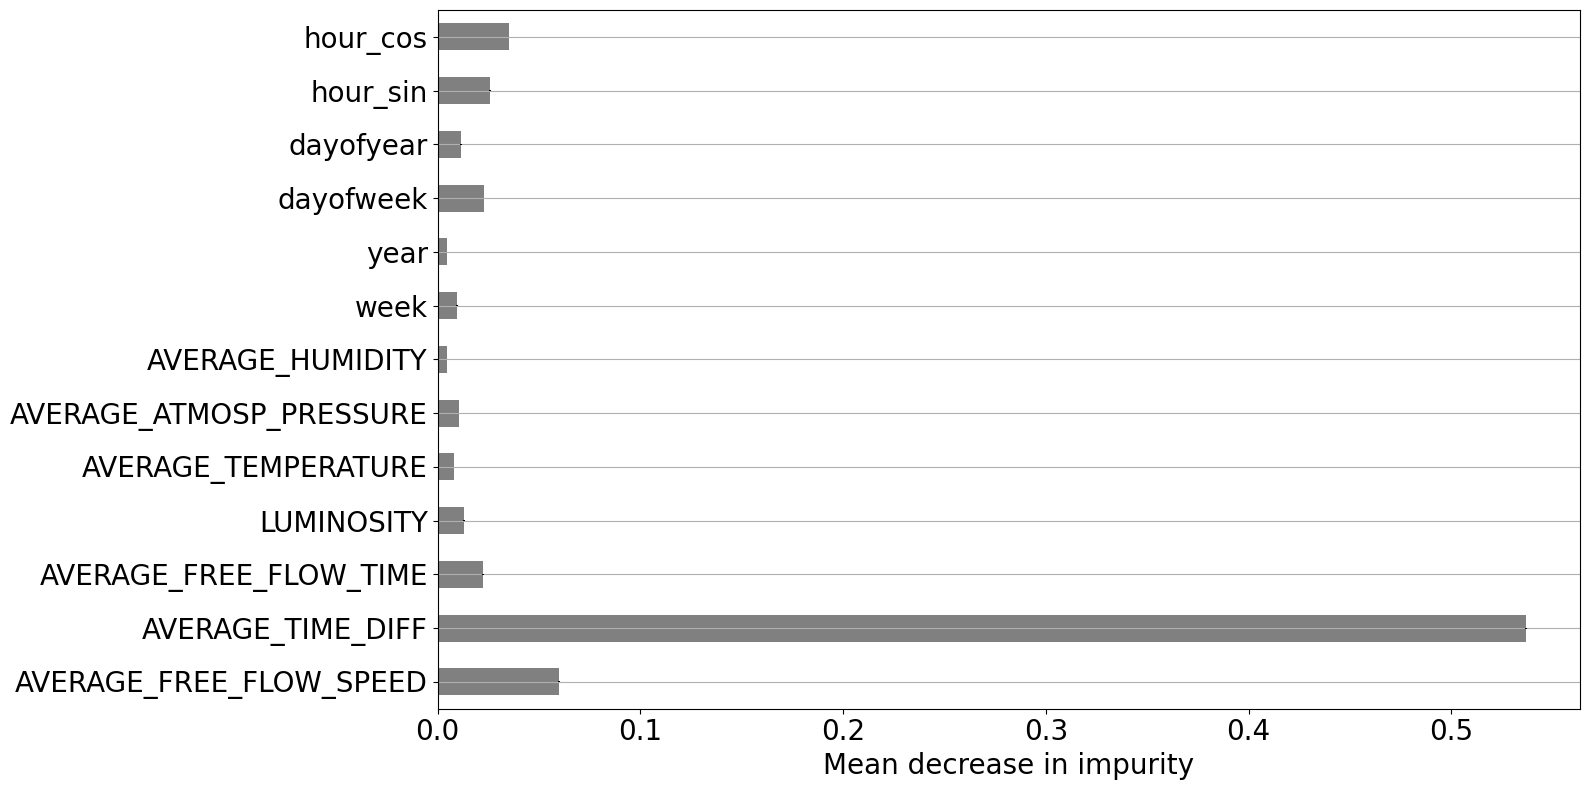

In [5]:
start_time = time.time()

result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
p_importances = pd.Series(result.importances_mean, index=X_val.columns)
print("Feature importances using PI:\n", p_importances.sort_values(ascending=False))
fig, ax = plt.subplots(figsize=(16,8))
p_importances.plot.barh(yerr=result.importances_std, ax=ax,color='grey')
ax.grid(axis='y')
ax.set_xlabel("Mean decrease in impurity", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
fig.tight_layout()
plt.show()

### *Stacking*

### **Submission Preparation**

In [9]:
# Exportar modelo treinado
import joblib
joblib.dump(model, 'Stacking.pkl')

['Stacking.pkl']

In [6]:
# Previsões no conjunto de teste
y_test = model.predict(X_test)

In [7]:
# Desmapeamento dos valores preditos para as categorias originais
inverse_map = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
y_test = pd.Series(y_test).map(inverse_map)

In [8]:
# Criar CSV de submissão
submission = pd.DataFrame({'RowId': range(1, len(X_test)+1), 'Speed_Diff': y_test})
submission.to_csv('submission.csv', index=False)